In [1]:
import sys

sys.path.insert(1, "../")

In [2]:
from em_algo.models import WeibullModelExp, GaussianModel, ExponentialModel
from em_algo.types import *
from em_algo import DistributionMixture, DistributionInMixture
from examples.utils import SingleSolverResult

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import itertools

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

In [3]:
from examples.utils import *
from examples.prepare_result import prepare_diff
from examples.config import RESULTS_FOLDER
import os.path

In [4]:
TEST_NAME = "diff_test"
SAVE_CSV = True

In [5]:
if os.path.isfile(RESULTS_FOLDER / (TEST_NAME + ".csv")):
    print(f"loading from file {TEST_NAME}.csv")
    df = pd.read_csv(RESULTS_FOLDER / (TEST_NAME + ".csv"))
elif os.path.isfile(RESULTS_FOLDER / (TEST_NAME + ".pkl")):
    print(f"loading and preparing from file {TEST_NAME}.pkl")
    print("this may take a time")
    results = open_results(TEST_NAME)
    df = prepare_diff(results)
    results = []
    df["occur"] = df["occur"].replace([np.inf, -np.inf], np.nan)
    if SAVE_CSV:
        print(f"saving prepared table to {TEST_NAME}.csv")
        df.to_csv(RESULTS_FOLDER / (TEST_NAME + ".csv"))
else:
    print(
        f"there is no file named {RESULTS_FOLDER / TEST_NAME}.csv in folder examples\\results"
    )
    print(
        f"there is no file named {RESULTS_FOLDER / TEST_NAME}.pkl in folder examples\\results"
    )
    exit()

loading and preparing from file diff_test.pkl
this may take a time


  0%|          | 0/35840 [00:00<?, ?it/s]

In [ ]:
df["error"].unique()

array([None], dtype=object)

In [ ]:
df = df.drop(columns=["error"])

In [ ]:
df["success"] = (df["steps"] < 16) & any(df["result_mixture"].values)

In [ ]:
df["success"].value_counts()

success
True     21584
False    14256
Name: count, dtype: int64

In [ ]:
df["failed"].value_counts()

failed
False    35792
True        48
Name: count, dtype: int64

In [ ]:
df.head()

,test_index,optimizer,k,sample,true_mixture,result_mixture,log,steps,time,model,size,success,failed,occur,start,diff,res_err
0,0,ScipyCG,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],8,0.664283,Gaussian,50,True,False,-2.785931,0.0,-5.0,0.875977
1,0,ScipyNewtonCG,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],8,0.476370,Gaussian,50,True,False,-2.785931,0.0,-5.0,0.875977
2,0,ScipySLSQP,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],8,0.405045,Gaussian,50,True,False,-2.785931,0.0,-5.0,0.875977
3,0,ScipyTNC,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,1.135967,Gaussian,50,False,False,-2.787035,0.0,-5.0,0.658691
4,1,ScipyCG,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,1.258066,Gaussian,50,False,False,-2.854913,0.0,-5.0,0.600586


In [ ]:
df.select_dtypes(["number", "bool"])

,test_index,k,steps,time,size,success,failed,occur,start,diff,res_err
0,0,2,8,0.664283,50,True,False,-2.785931,0.0,-5.0,0.875977
1,0,2,8,0.476370,50,True,False,-2.785931,0.0,-5.0,0.875977
2,0,2,8,0.405045,50,True,False,-2.785931,0.0,-5.0,0.875977
3,0,2,16,1.135967,50,False,False,-2.787035,0.0,-5.0,0.658691
4,1,2,16,1.258066,50,False,False,-2.854913,0.0,-5.0,0.600586
...,...,...,...,...,...,...,...,...,...,...,...
35835,8958,2,11,17.186619,1000,True,False,0.364794,5.0,10.0,0.004395
35836,8959,2,16,42.623216,1000,False,False,0.368635,5.0,10.0,0.036621
35837,8959,2,16,29.251203,1000,False,False,0.368636,5.0,10.0,0.036621
35838,8959,2,16,22.657641,1000,False,False,0.368636,5.0,10.0,0.036621


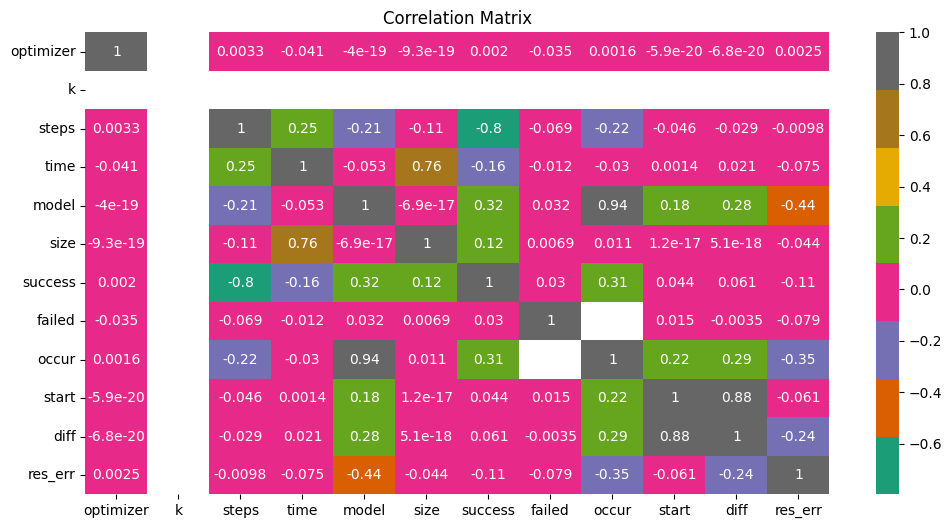

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
categorical_cols = (
    df.drop(columns=["true_mixture", "result_mixture", "sample", "log"])
    .select_dtypes(include=["object"])
    .columns
)

corr_df = pd.DataFrame(df)

for col in categorical_cols:
    corr_df[col] = le.fit_transform(df[col])

corr_df = corr_df.select_dtypes(["number", "bool"])
corr_df = corr_df.drop(columns=["test_index"])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
corr_df = pd.DataFrame(scaler.fit_transform(corr_df), columns=corr_df.columns)

df_corr = corr_df.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(df_corr, annot=True, cmap="Dark2")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
df[df["optimizer"] == "ScipyNewtonCG"]

,test_index,optimizer,k,sample,true_mixture,result_mixture,log,steps,time,model,size,success,failed,occur,start,diff,res_err
1,0,ScipyNewtonCG,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],8,0.476370,Gaussian,50,True,False,-2.785931,0.0,-5.0,0.875977
5,1,ScipyNewtonCG,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,0.972659,Gaussian,50,False,False,-2.854913,0.0,-5.0,0.600586
9,2,ScipyNewtonCG,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],14,0.390044,Gaussian,50,True,False,-2.787016,0.0,-5.0,0.481934
13,3,ScipyNewtonCG,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],4,0.212232,Gaussian,50,True,False,-2.786844,0.0,-5.0,0.821289
17,4,ScipyNewtonCG,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],15,0.830132,Gaussian,50,True,False,-2.855098,0.0,-5.0,0.601074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35821,8955,ScipyNewtonCG,2,"[0.8337094617426717, 1.269151539209708, 1.0184...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,31.412407,WeibullExp,1000,False,False,0.368902,5.0,10.0,0.038086
35825,8956,ScipyNewtonCG,2,"[0.8337094617426717, 1.269151539209708, 1.0184...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,27.625445,WeibullExp,1000,False,False,0.377802,5.0,10.0,0.086426
35829,8957,ScipyNewtonCG,2,"[0.8337094617426717, 1.269151539209708, 1.0184...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],4,2.859917,WeibullExp,1000,True,False,0.369999,5.0,10.0,0.016113
35833,8958,ScipyNewtonCG,2,"[0.8337094617426717, 1.269151539209708, 1.0184...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],11,18.960894,WeibullExp,1000,True,False,0.364794,5.0,10.0,0.004395


In [ ]:
for opt in df["optimizer"].unique():
    print(opt)
    print(df[df["optimizer"] == opt]["failed"].value_counts())
    print("time")
    print(df[df["optimizer"] == opt]["time"].mean())
    print("steps")
    print(df[df["optimizer"] == opt]["steps"].mean())
    print("occur")
    print(df[df["optimizer"] == opt]["occur"].mean())
    print()

ScipyCG
failed
False    8931
True       29
Name: count, dtype: int64
time
5.8576890760498435
steps
11.299888392857143
occur
-1.4263947042995095

ScipyNewtonCG
failed
False    8942
True       18
Name: count, dtype: int64
time
4.453234005604547
steps
11.313169642857142
occur
-1.4255803637953273

ScipySLSQP
failed
False    8959
True        1
Name: count, dtype: int64
time
3.652828908520979
steps
11.320982142857142
occur
-1.4224399518807107

ScipyTNC
failed
False    8960
Name: count, dtype: int64
time
5.355842513922247
steps
11.344642857142857
occur
-1.4222293538905961



In [ ]:
print(df["occur"].min())
print(df["occur"].max())

-2.9252330205989385
0.3818092024043968


In [ ]:
mdf = df[df["k"] > 1]
mdf

,test_index,optimizer,k,sample,true_mixture,result_mixture,log,steps,time,model,size,success,failed,occur,start,diff,res_err
0,0,ScipyCG,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],8,0.664283,Gaussian,50,True,False,-2.785931,0.0,-5.0,0.875977
1,0,ScipyNewtonCG,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],8,0.476370,Gaussian,50,True,False,-2.785931,0.0,-5.0,0.875977
2,0,ScipySLSQP,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],8,0.405045,Gaussian,50,True,False,-2.785931,0.0,-5.0,0.875977
3,0,ScipyTNC,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,1.135967,Gaussian,50,False,False,-2.787035,0.0,-5.0,0.658691
4,1,ScipyCG,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,1.258066,Gaussian,50,False,False,-2.854913,0.0,-5.0,0.600586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35835,8958,ScipyTNC,2,"[0.8337094617426717, 1.269151539209708, 1.0184...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],11,17.186619,WeibullExp,1000,True,False,0.364794,5.0,10.0,0.004395
35836,8959,ScipyCG,2,"[0.8337094617426717, 1.269151539209708, 1.0184...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,42.623216,WeibullExp,1000,False,False,0.368635,5.0,10.0,0.036621
35837,8959,ScipyNewtonCG,2,"[0.8337094617426717, 1.269151539209708, 1.0184...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,29.251203,WeibullExp,1000,False,False,0.368636,5.0,10.0,0.036621
35838,8959,ScipySLSQP,2,"[0.8337094617426717, 1.269151539209708, 1.0184...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,22.657641,WeibullExp,1000,False,False,0.368636,5.0,10.0,0.036621


In [ ]:
calc_success_rate_hash = dict()


def calc_success_rate(row, column):
    k = row["k"]
    size = row["size"]
    model = row["model"]
    optimizer = row["optimizer"]

    if (k, size, model, optimizer) in calc_success_rate_hash:
        return calc_success_rate_hash[(k, size, model, optimizer)]

    dfoi = mdf[
        (mdf["k"] == k)
        & (mdf["size"] == size)
        & (mdf["model"] == model)
        & (mdf["optimizer"] == optimizer)
    ]

    calc_success_rate_hash[(k, size, model, optimizer)] = (
        dfoi[column].sum() / len(dfoi) * 100
    )

    return calc_success_rate_hash[(k, size, model, optimizer)]


mdf["success_rate"] = mdf.apply(partial(calc_success_rate, column="success"), axis=1)
calc_success_rate_hash = dict()
mdf["fail_rate"] = mdf.apply(partial(calc_success_rate, column="failed"), axis=1)

In [ ]:
mdf

,test_index,optimizer,k,sample,true_mixture,result_mixture,log,steps,time,model,size,success,failed,occur,start,diff,res_err,success_rate,fail_rate
0,0,ScipyCG,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],8,0.664283,Gaussian,50,True,False,-2.785931,0.0,-5.0,0.875977,30.078125,0.000000
1,0,ScipyNewtonCG,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],8,0.476370,Gaussian,50,True,False,-2.785931,0.0,-5.0,0.875977,30.078125,0.000000
2,0,ScipySLSQP,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],8,0.405045,Gaussian,50,True,False,-2.785931,0.0,-5.0,0.875977,30.078125,0.000000
3,0,ScipyTNC,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,1.135967,Gaussian,50,False,False,-2.787035,0.0,-5.0,0.658691,30.859375,0.000000
4,1,ScipyCG,2,"[-3.527075145085246, -8.884044427162717, -8.27...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,1.258066,Gaussian,50,False,False,-2.854913,0.0,-5.0,0.600586,30.078125,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35835,8958,ScipyTNC,2,"[0.8337094617426717, 1.269151539209708, 1.0184...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],11,17.186619,WeibullExp,1000,True,False,0.364794,5.0,10.0,0.004395,78.027344,0.000000
35836,8959,ScipyCG,2,"[0.8337094617426717, 1.269151539209708, 1.0184...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,42.623216,WeibullExp,1000,False,False,0.368635,5.0,10.0,0.036621,78.417969,0.976562
35837,8959,ScipyNewtonCG,2,"[0.8337094617426717, 1.269151539209708, 1.0184...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,29.251203,WeibullExp,1000,False,False,0.368636,5.0,10.0,0.036621,78.320312,0.097656
35838,8959,ScipySLSQP,2,"[0.8337094617426717, 1.269151539209708, 1.0184...",(<em_algo.distribution_mixture.DistributionInM...,(<em_algo.distribution_mixture.DistributionInM...,[],16,22.657641,WeibullExp,1000,False,False,0.368636,5.0,10.0,0.036621,78.320312,0.000000


In [ ]:
mdf["diff"] = mdf["diff"].apply(lambda x: "{:,.2f}".format(x))
mdf["res_err"] = (mdf["res_err"] * 100).apply(int)
mdf = mdf.drop(mdf[mdf["start"] == 1.0].index)

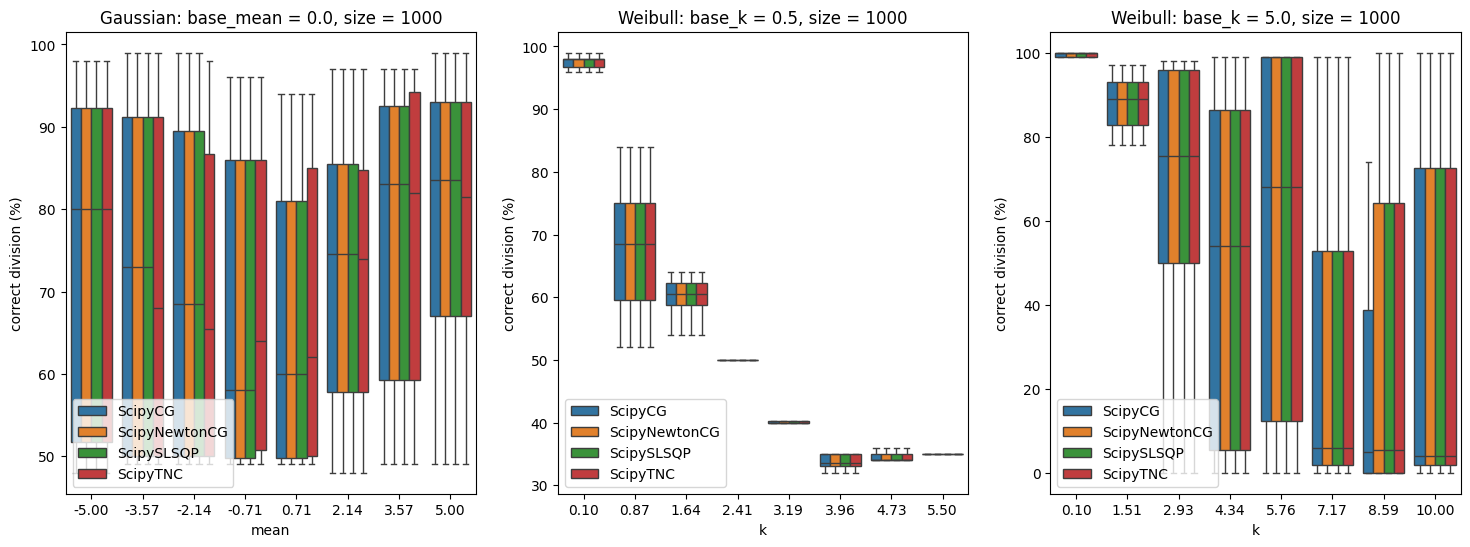

In [ ]:
cdf = mdf[mdf["model"] == "Gaussian"]

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(
    ax=ax[0],
    data=cdf[(cdf["start"] == 0.0) & (cdf["size"] == 1000)],
    x="diff",
    y="res_err",
    hue="optimizer",
    showfliers=False,
)
ax[0].set_ylabel("correct division (%)")
ax[0].set_xlabel("mean")
ax[0].set_title(f"Gaussian: base_mean = 0.0, size = 1000")

cdf = mdf[mdf["model"] == "WeibullExp"]

sns.boxplot(
    ax=ax[1],
    data=cdf[(cdf["start"] == 0.5) & (cdf["size"] == 1000)],
    x="diff",
    y="res_err",
    hue="optimizer",
    showfliers=False,
)
ax[1].set_ylabel("correct division (%)")
ax[1].set_xlabel("k")
ax[1].set_title(f"Weibull: base_k = 0.5, size = 1000")

sns.boxplot(
    ax=ax[2],
    data=cdf[(cdf["start"] == 5.0) & (cdf["size"] == 1000)],
    x="diff",
    y="res_err",
    hue="optimizer",
    showfliers=False,
)
ax[2].set_ylabel("correct division (%)")
ax[2].set_xlabel("k")
ax[2].set_title(f"Weibull: base_k = 5.0, size = 1000")

for i in range(3):
    ax[i].legend(loc="lower left")

plt.show()